In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
from torch.utils.data import Dataset, DataLoader
from cvxpylayers.torch import CvxpyLayer
from tqdm import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import torch.autograd as autograd
from itertools import accumulate

In [2]:
# Dataset creation
def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
    returns = data.pct_change().dropna()
    return returns

In [3]:
class PortfolioDataset(Dataset):
    def __init__(self, returns_data, subseries_len=128):
        self.returns_data = returns_data
        self.subseries_len = subseries_len
        self.mu_tags = []
        self.sigma_tags = []

        for i in range(len(returns_data) - subseries_len):
            subseries = returns_data[i:i + subseries_len]
            sample_mu = subseries.mean(dim=0)
            sample_sigma = torch.cov(subseries.T)
            self.mu_tags.append(sample_mu)
            self.sigma_tags.append(sample_sigma)

    def __len__(self):
        return len(self.returns_data) - self.subseries_len

    def __getitem__(self, idx):
        subseries = self.returns_data[idx:idx + self.subseries_len]
        mu_tag = self.mu_tags[idx]
        sigma_tag = self.sigma_tags[idx]
        return subseries, mu_tag, sigma_tag

In [4]:
# Model definition
class PortfolioNet(nn.Module):
    def __init__(self, input_dim, n_assets):
        super(PortfolioNet, self).__init__()
        self.fc_mu = nn.Linear(input_dim, n_assets)
        self.fc_L = nn.Linear(input_dim, n_assets * (n_assets + 1) // 2)

    def forward(self, x):
        mu = self.fc_mu(x.reshape(x.shape[0], -1))
        L_flat = self.fc_L(x.reshape(x.shape[0], -1))

        indices = torch.tril_indices(x.shape[2], x.shape[2], offset=0)
        L = torch.zeros(x.shape[0], x.shape[2], x.shape[2])
        for i in range(x.shape[0]):
            L[i, indices[0], indices[1]] = L_flat[i]

        Sigma = torch.matmul(L, L.transpose(1, 2))

        return mu, Sigma, L

In [5]:
import time

In [6]:
class EnvelopeLayer(nn.Module):
    def __init__(self, variables, parameters, objective, inequalities, equalities, **cvxpy_opts):
        super().__init__()
        self.variables = variables
        self.parameters = parameters
        self.objective = objective
        self.inequalities = inequalities
        self.equalities = equalities
        self.cvxpy_opts = cvxpy_opts

        self.cp_inequalities = [ineq(*variables, *parameters) <= 0 for ineq in inequalities]
        self.cp_equalities = [eq(*variables, *parameters) == 0 for eq in equalities]
        self.problem = cp.Problem(
            cp.Minimize(objective(*variables, *parameters)),
            self.cp_inequalities + self.cp_equalities
        )
        self.saved_params = None
        self.saved_solution = None

    def forward(self, *batch_params):
        out = []
        inp = []
        z_star = []
        lam_star = []
        nu_star = []
        
        for batch in range(batch_params[0].shape[0]):
            params = [p[batch] for p in batch_params]
            with torch.no_grad():
                for i, p in enumerate(self.parameters):
                    p.value = params[i].double().numpy()
                self.problem.solve(**self.cvxpy_opts)

                z = [torch.tensor(v.value, dtype=params[0].dtype, device=params[0].device) for v in self.variables]
                lam = [torch.tensor(c.dual_value, dtype=params[0].dtype, device=params[0].device)
                       for c in self.cp_inequalities]
                nu = [torch.tensor(c.dual_value, dtype=params[0].dtype, device=params[0].device)
                      for c in self.cp_equalities]
                optimal_val = torch.tensor(self.problem.value, dtype=params[0].dtype, device=params[0].device)
            optimal_val.requires_grad = True
            
            out.append(optimal_val)
            inp.append(params)
            z_star.append(z)
            lam_star.append(lam)
            nu_star.append(nu)

        out = torch.stack(out, dim=0)
        self.saved_params = inp
        self.saved_solution = z_star, lam_star, nu_star
        
        return out
    
    def backward(self, grad_output):
        print("checkpoint")
        grad_inputs = []
        for params, solution, grad_out in zip(self.saved_params, self.saved_solution, grad_output):
            z, lam, nu = solution
            
            g = [ineq(*z, *params) for ineq in self.inequalities]
            h = [eq(*z, *params) for eq in self.equalities]
            L = (self.objective(*z, *params) +
                     sum((u*v).sum() for u,v in zip(lam,g)) +
                     sum((u*v).sum() for u,v in zip(nu,h)))
            
            dproblem = autograd.grad(L, params, create_graph=True)
            
            grad_inputs.append([g * grad_out for g in dproblem])
        
        return tuple(torch.stack(grads) for grads in zip(*grad_inputs))

In [7]:
class EnvelopeLayer(nn.Module):
    def __init__(self, variables, parameters, objective, inequalities, equalities, **cvxpy_opts):
        super().__init__()
        self.variables = variables
        self.parameters = parameters
        self.objective = objective
        self.inequalities = inequalities
        self.equalities = equalities
        self.cvxpy_opts = cvxpy_opts

        self.cp_inequalities = [ineq(*variables, *parameters) <= 0 for ineq in inequalities]
        self.cp_equalities = [eq(*variables, *parameters) == 0 for eq in equalities]
        self.problem = cp.Problem(
            cp.Minimize(objective(*variables, *parameters)),
            self.cp_inequalities + self.cp_equalities
        )

    def forward(self, *batch_params):
        batch_size = batch_params[0].shape[0]
        outputs = []
        gradients = []

        for batch in range(batch_size):
            params = [p[batch] for p in batch_params]
            with torch.no_grad():
                # Solve optimization problem
                for i, p in enumerate(self.parameters):
                    p.value = params[i].double().numpy()
                self.problem.solve(**self.cvxpy_opts)

            # Retrieve variables and dual variables
            z = [torch.tensor(v.value, dtype=params[0].dtype, device=params[0].device) for v in self.variables]
            lam = [torch.tensor(c.dual_value, dtype=params[0].dtype, device=params[0].device)
                   for c in self.cp_inequalities]
            nu = [torch.tensor(c.dual_value, dtype=params[0].dtype, device=params[0].device)
                  for c in self.cp_equalities]
            optimal_val = torch.tensor(self.problem.value, dtype=params[0].dtype, device=params[0].device)
            
            # Requires grad to enable autograd for envelope theorem-based computation
            for param in params:
                param.requires_grad_(True)

            # Define Lagrangian
            g = [ineq(*z, *params) for ineq in self.inequalities]
            h = [eq(*z, *params) for eq in self.equalities]
            L = (self.objective(*z, *params) +
                 sum((u * v).sum() for u, v in zip(lam, g)) +
                 sum((u * v).sum() for u, v in zip(nu, h)))

            # Compute derivatives using the envelope theorem
            dproblem = autograd.grad(L, params, create_graph=True)
            
            # Save outputs and gradients for each batch
            outputs.append(optimal_val)
            gradients.append(dproblem)

        # Stack results for batch dimension
        output_tensor = torch.stack(outputs)
        self.saved_gradients = gradients  # Save gradients for backward pass
        return output_tensor

    def backward(self, grad_output):
        # Backpropagate gradient through saved gradients from forward pass
        print("checkpoint2")
        grad_inputs = []
        for grad, grad_out in zip(self.saved_gradients, grad_output):
            grad_inputs.append([g * grad_out for g in grad])
        return tuple(torch.stack(g) for g in zip(*grad_inputs))


In [8]:
import torch
import torch.nn as nn
import torch.autograd as autograd

class EnvelopeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, input, *params):
        """
        Save necessary context for backward computation and return the output.
        """
        # Save input and any other parameters for backward pass
        ctx.save_for_backward(input, *params)
        
        # Perform your custom forward computation
        # (Example: return input squared)
        output = input ** 2  # Replace with your actual forward computation
        return output

    @staticmethod
    def backward(ctx, grad_output):
        """
        Calculate and return gradients for inputs and any parameters.
        grad_output is the gradient of the loss w.r.t the output of this layer.
        """
        # Retrieve saved tensors
        input, *params = ctx.saved_tensors

        # Compute your custom gradient
        # (Example: grad_input is 2 * input * grad_output)
        grad_input = 2 * input * grad_output  # Replace with your closed-form gradient computation
        
        # If there are additional parameters, compute their gradients here as well
        # grad_params = ...

        return grad_input, *(None for _ in params)  # Return gradients for inputs and params

# Define a PyTorch module that uses this custom function
class EnvelopeLayer(nn.Module):
    def __init__(self):
        super(EnvelopeLayer, self).__init__()
        # Add any initialization logic if needed

    def forward(self, *batch_input):
        # Use the custom function in forward
        return EnvelopeFunction.apply(*batch_input)

In [9]:
# Define your layer
layer = EnvelopeLayer()

# Input tensor
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# Forward pass
y = layer(x)

# Backward pass
y.sum().backward()

# Check the gradient
print(x.grad)  # Should match your closed-form gradient


tensor([2., 4., 6.])


In [72]:
def create_cvxpy_layer(n, lambda_):
    x = cp.Variable(n)
    P_sqrt = cp.Parameter((n, n))
    mu_param = cp.Parameter(n)

    quad_form = cp.sum_squares(P_sqrt @ x)
    objective = cp.Minimize(0.5 * quad_form - lambda_ * mu_param.T @ x)
    constraints = [cp.sum(x) == 1, x >= 0]
    problem = cp.Problem(objective, constraints)
    assert problem.is_dpp(), "Problem is not DPP compliant."
    cvxpylayer = CvxpyLayer(problem, parameters=[mu_param, P_sqrt], variables=[x])
    return cvxpylayer

In [73]:
# Training step
np.random.seed(42)
torch.manual_seed(42)

tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA',  # Technology
    'PG', 'KO', 'PEP', 'WMT', 'COST',  # Consumer Goods
    'JNJ', 'PFE', 'MRK', 'ABT', 'AMGN',  # Healthcare
    'JPM', 'BAC', 'WFC', 'C', 'GS',  # Financials
    'XOM', 'CVX', 'COP', 'SLB', 'OXY',  # Energy
    'BA', 'CAT', 'UPS', 'DE', 'MMM',  # Industrials
    'DIS', 'TGT', 'MCD', 'LVMUY', 'NFLX',  # Consumer Services
    'LIN', 'NEM', 'CL', 'VMC', 'FCX',  # Materials
    'AMT', 'PLD', 'SPG', 'O', 'EQIX',  # Real Estate
    'NEE', 'DUK', 'XEL', 'SO', 'EXC'  # Utilities
]
returns = download_data(tickers, start_date='2015-01-01', end_date='2024-01-01')
returns = returns.values

returns_tensor = torch.tensor(returns, dtype=torch.float32)

subseries_len = 28

dataset = PortfolioDataset(returns_tensor, subseries_len=subseries_len)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

n_assets = len(tickers)
input_dim = n_assets * subseries_len

model = PortfolioNet(input_dim=input_dim, n_assets=n_assets)

optimizer = optim.Adam(model.parameters(), lr=0.001)

lambda_, alpha, beta, gamma = 0.5, 0, 0, 1  # Weights mu loss, Sigma loss, portfolio loss 

z = cp.Variable(n_assets)
L = cp.Parameter((n_assets, n_assets))
mu = cp.Parameter(n_assets)

def f_(z, L, mu):
    return 0.5 * cp.sum_squares(L @ z) - lambda_*mu.T @ z if isinstance(z, cp.Variable) else 0.5*torch.sum((L @ z)**2) - lambda_*mu@z
def g_(z, L, mu):
    return -z
def h_(z, L, mu):
    return cp.sum(z) - 1 if isinstance(z, cp.Variable) else torch.sum(z) - 1

envelope_layer = EnvelopeLayer(variables=[z], parameters=[L, mu], 
         objective=f_, inequalities=[g_], equalities=[h_])

num_epochs = 5
memory_stored = 0
for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0)
    for _, (features_batch, mu_tags_batch, sigma_tags_batch) in progress_bar:
        optimizer.zero_grad()
        init_memory = torch.cuda.memory_allocated()
        
        mu_hat, Sigma_hat, L_hat = model(features_batch)
        
        mu_loss = torch.mean((mu_hat - mu_tags_batch) ** 2)
        sigma_loss = torch.mean((Sigma_hat - sigma_tags_batch) ** 2)
        def hook_fn(grad):
            return
            print(grad)
        
        mu_hat.register_hook(hook_fn)
        optimal_values = envelope_layer.forward(L_hat, mu_hat)
        
        after_forward_memory = torch.cuda.memory_allocated()
        
        portfolio_loss = torch.mean(optimal_values)
        memory_stored += after_forward_memory - init_memory
        total_loss =  alpha*mu_loss  + beta*sigma_loss + gamma*portfolio_loss
        total_loss.backward()
        
        optimizer.step()
        epoch_loss += total_loss.item() * features_batch.size(0)
    
    epoch_loss /= len(dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}')
# print(f"Average memory stored from forward pass: {(memory_stored/(len(dataloader) * num_epochs)) / 1e6:.2f} MB")  # Needs to run on CUDA, if not output is 0!

Epoch 1/5: 100%|██████████| 70/70 [00:07<00:00,  8.82it/s]


Epoch 1/5, Loss: -0.016401


Epoch 2/5: 100%|██████████| 70/70 [00:07<00:00,  8.87it/s]


Epoch 2/5, Loss: -0.016401


Epoch 3/5:  40%|████      | 28/70 [00:03<00:04,  8.75it/s]


Solver interrupted


ValueError: OSQP solve error!

In [ ]:
# Inference Step
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA',  # Technology
    'PG', 'KO', 'PEP', 'WMT', 'COST',  # Consumer Goods
    'JNJ', 'PFE', 'MRK', 'ABT', 'AMGN',  # Healthcare
    'JPM', 'BAC', 'WFC', 'C', 'GS',  # Financials
    'XOM', 'CVX', 'COP', 'SLB', 'OXY',  # Energy
    'BA', 'CAT', 'UPS', 'DE', 'MMM',  # Industrials
    'DIS', 'TGT', 'MCD', 'LVMUY', 'NFLX',  # Consumer Services
    'LIN', 'NEM', 'CL', 'VMC', 'FCX',  # Materials
    'AMT', 'PLD', 'SPG', 'O', 'EQIX',  # Real Estate
    'NEE', 'DUK', 'XEL', 'SO', 'EXC'  # Utilities
]

rebalance_dates = [datetime(2024, month, 1) for month in range(1, 11)]

start_date = (rebalance_dates[0] - relativedelta(months=2)).strftime('%Y-%m-%d')
end_date = rebalance_dates[-1].strftime('%Y-%m-%d')
all_data = download_data(tickers, start_date=start_date, end_date=end_date)

portfolio_values_pred = [1.0]
portfolio_values_real = [1.0]
portfolio_values_equal = [1.0]
dates = [rebalance_dates[0]]
portfolio_returns_pred = []
portfolio_returns_real = []
portfolio_returns_equal = []

for i in range(len(rebalance_dates) - 1):
    rebalance_date = rebalance_dates[i]
    next_rebalance_date = rebalance_dates[i + 1]

    estimation_start_date = rebalance_date - relativedelta(months=2)
    estimation_end_date = rebalance_date
    holding_start_date = rebalance_date
    holding_end_date = next_rebalance_date

    returns_estimation = all_data.loc[estimation_start_date:estimation_end_date]
    returns_holding = all_data.loc[holding_start_date:holding_end_date]

    returns = returns_estimation.values
    returns_tensor = torch.tensor(returns, dtype=torch.float32)

    subseries_len = 28
    dataset = PortfolioDataset(returns_tensor, subseries_len=subseries_len)

    n_assets = len(tickers)
    input_dim = n_assets * subseries_len

    with torch.no_grad():
        features_batch, mu_tags_batch, sigma_tags_batch = dataset[0]
        features_batch = features_batch.unsqueeze(0)

        mu_hat, Sigma_hat, _ = model(features_batch)

        mu_pred = mu_hat[0].cpu().numpy()
        Sigma_pred = Sigma_hat[0].cpu().numpy()

        mu_real = np.mean(returns, axis=0)
        Sigma_real = np.cov(returns, rowvar=False)


    def mean_variance_optimization(mu, Sigma, risk_aversion=1.0):
        n = len(mu)
        w = cp.Variable(n)
        objective = cp.Maximize(mu @ w - risk_aversion / 2 * cp.quad_form(w, Sigma))
        constraints = [cp.sum(w) == 1, w >= 0]
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS)
        return w.value


    w_pred = mean_variance_optimization(mu_pred, Sigma_pred)
    w_real = mean_variance_optimization(mu_real, Sigma_real)

    w_pred = np.maximum(w_pred, 0)
    w_pred /= np.sum(w_pred)
    w_real = np.maximum(w_real, 0)
    w_real /= np.sum(w_real)
    w_equal = np.ones(n_assets) / n_assets

    returns_holding_values = returns_holding.values
    pred_returns = returns_holding_values @ w_pred
    real_returns = returns_holding_values @ w_real
    equal_returns = returns_holding_values @ w_equal

    portfolio_returns_pred.extend(pred_returns)
    portfolio_returns_real.extend(real_returns)
    portfolio_returns_equal.extend(equal_returns)

    cumulative_return_pred = np.prod(1 + pred_returns)
    cumulative_return_real = np.prod(1 + real_returns)
    cumulative_return_equal = np.prod(1 + equal_returns)

    new_value_pred = portfolio_values_pred[-1] * cumulative_return_pred
    new_value_real = portfolio_values_real[-1] * cumulative_return_real
    new_value_equal = portfolio_values_equal[-1] * cumulative_return_equal

    portfolio_values_pred.append(new_value_pred)
    portfolio_values_real.append(new_value_real)
    portfolio_values_equal.append(new_value_equal)
    dates.append(next_rebalance_date)


# Calculate drawdowns
def calculate_drawdown(portfolio_values):
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdown = (portfolio_values - cumulative_max) / cumulative_max
    return drawdown


drawdown_pred = calculate_drawdown(portfolio_values_pred)
drawdown_real = calculate_drawdown(portfolio_values_real)
drawdown_equal = calculate_drawdown(portfolio_values_equal)


# Calculate Sharpe ratios
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = np.array(returns) - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)


sharpe_pred = calculate_sharpe_ratio(portfolio_returns_pred)
sharpe_real = calculate_sharpe_ratio(portfolio_returns_real)
sharpe_equal = calculate_sharpe_ratio(portfolio_returns_equal)

print(f"Sharpe Ratio (Predicted Portfolio): {sharpe_pred:.4f}")
print(f"Sharpe Ratio (Sample Portfolio): {sharpe_real:.4f}")
print(f"Sharpe Ratio (Equally Weighted Portfolio): {sharpe_equal:.4f}")

# Plot portfolio values
plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_values_pred, marker='o', label='Predicted MV Portfolio')
plt.plot(dates, portfolio_values_real, marker='o', label='Sample MV Portfolio')
plt.plot(dates, portfolio_values_equal, marker='o', label='Equally Weighted Portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Backtest from 2024-01-01 to 2024-10-01')
plt.legend()
plt.grid(True)
plt.show()

# Plot drawdown as an area plot
plt.figure(figsize=(12, 6))
plt.fill_between(dates, drawdown_pred, color='blue', alpha=0.3, label='Predicted Portfolio Drawdown')
plt.fill_between(dates, drawdown_real, color='orange', alpha=0.3, label='Sample Portfolio Drawdown')
plt.fill_between(dates, drawdown_equal, color='green', alpha=0.3, label='Equally Weighted Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Portfolio Drawdown from 2024-01-01 to 2024-10-01')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from itertools import accumulate

class OptLayer(nn.Module):
    def __init__(self, variables, parameters, objective, inequalities, equalities, **cvxpy_opts):
        super().__init__()
        self.variables = variables
        self.parameters = parameters
        self.objective = objective
        self.inequalities = inequalities
        self.equalities = equalities
        self.cvxpy_opts = cvxpy_opts
        
        # create the cvxpy problem with objective, inequalities, equalities
        self.cp_inequalities = [ineq(*variables, *parameters) <= 0 for ineq in inequalities]
        self.cp_equalities = [eq(*variables, *parameters) == 0 for eq in equalities]
        self.problem = cp.Problem(cp.Minimize(objective(*variables, *parameters)), 
                                  self.cp_inequalities + self.cp_equalities)
        
    def forward(self, *batch_params):
        out, J = [], []
        # solve over minibatch by just iterating
        for batch in range(batch_params[0].shape[0]):
            # solve the optimization problem and extract solution + dual variables
            params = [p[batch] for p in batch_params]
            with torch.no_grad():
                for i,p in enumerate(self.parameters):
                    p.value = params[i].double().numpy()
                self.problem.solve(**self.cvxpy_opts)
                z = [torch.tensor(v.value).type_as(params[0]) for v in self.variables]
                lam = [torch.tensor(c.dual_value).type_as(params[0]) for c in self.cp_inequalities]
                nu = [torch.tensor(c.dual_value).type_as(params[0]) for c in self.cp_equalities]

            # convenience routines to "flatten" and "unflatten" (z,lam,nu)
            def vec(z, lam, nu):
                return torch.cat([a.view(-1) for b in [z,lam,nu] for a in b])

            def mat(x):
                sz = [0] + list(accumulate([a.numel() for b in [z,lam,nu] for a in b]))
                val = [x[a:b] for a,b in zip(sz, sz[1:])]
                return ([val[i].view_as(z[i]) for i in range(len(z))],
                        [val[i+len(z)].view_as(lam[i]) for i in range(len(lam))],
                        [val[i+len(z)+len(lam)].view_as(nu[i]) for i in range(len(nu))])

            # computes the KKT residual
            def kkt(z, lam, nu, *params):
                g = [ineq(*z, *params) for ineq in self.inequalities]
                dnu = [eq(*z, *params) for eq in self.equalities]
                L = (self.objective(*z, *params) + 
                     sum((u*v).sum() for u,v in zip(lam,g)) + sum((u*v).sum() for u,v in zip(nu,dnu)))
                dz = autograd.grad(L, z, create_graph=True)
                dlam = [lam[i]*g[i] for i in range(len(lam))]
                return dz, dlam, dnu

            # compute residuals and re-engage autograd tape
            y = vec(z, lam, nu)
            y = y - vec(*kkt([z_.clone().detach().requires_grad_() for z_ in z], lam, nu, *params))

            # compute jacobian and backward hook
            J.append(autograd.functional.jacobian(lambda x: vec(*kkt(*mat(x), *params)), y))
            def hook_fn(grad, b=batch):
                print("Grad shape:")
                print(grad.shape)
                new = torch.linalg.solve(J[b].transpose(0,1), grad[:,None])[:,0]
                print("New shape:")
                print(new.shape)
                return new
            y.register_hook(hook_fn)
            
            out.append(mat(y)[0])
        out = [torch.stack(o, dim=0) for o in zip(*out)]
        return out[0] if len(out) == 1 else tuple(out)

In [35]:
z = cp.Variable(1)
x = cp.Parameter(1)
def f_(z,x):
    if isinstance(z, cp.Variable):
        return -cp.multiply(z,x) - cp.entr(z) - cp.entr(1-z)
    else:
        return -z*x + z*torch.log(z) + (1-z)*torch.log(1-z)

layer = OptLayer([z], [x], f_, [], [])

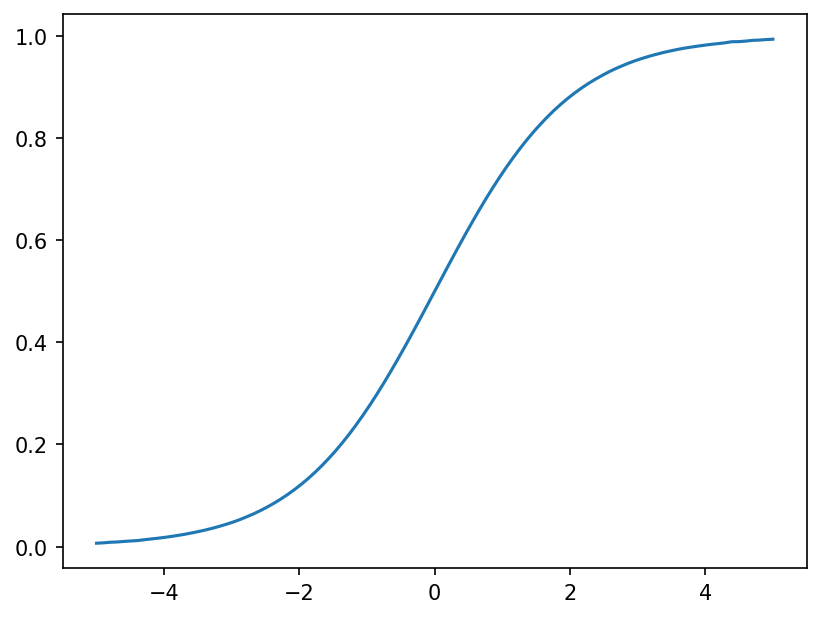

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

x = torch.linspace(-5,5,100).requires_grad_()
y = layer(x[:,None])[:,0]
plt.figure(dpi=150)
plt.plot(x.detach().numpy(), y.detach().numpy())

Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape:
torch.Size([1])
New shape:
torch.Size([1])
Grad shape

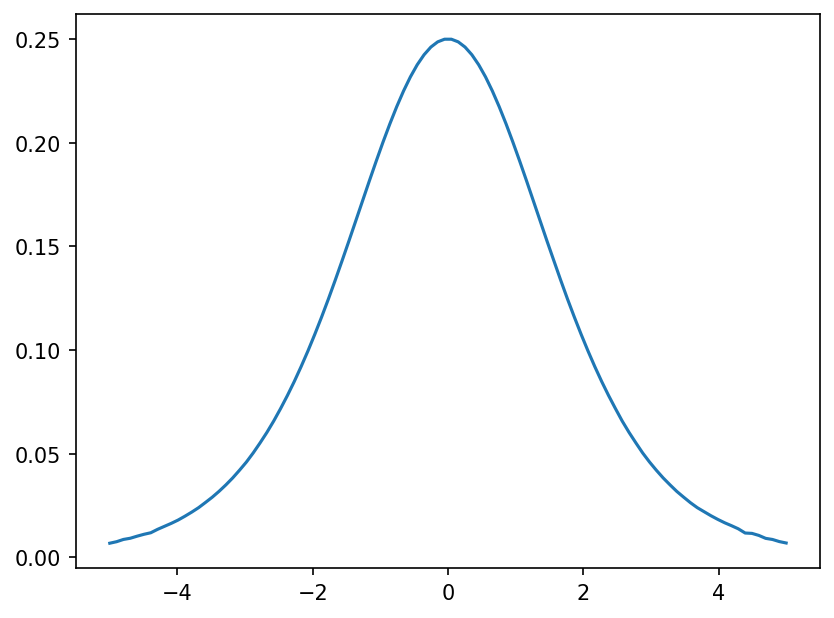

In [37]:
y.sum().backward()
plt.figure(dpi=150)
plt.plot(x.detach().numpy(), x.grad.detach().numpy())